In [2]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.utils import resample

# Image and Data Processing Libraries
from PIL import Image
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# PyTorch Vision Models
import torchvision.models as models

# Transformations Libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Weights and Biases (WandB)
import wandb
from sklearn.metrics import accuracy_score


In [3]:
df = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
df

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0      ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1      ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2      ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3      ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4      ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
...             ...  ...  ...  ...    ...  ...  ...   ...
10010  ISIC_0034316  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10011  ISIC_0034317  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10012  ISIC_0034318  0.0  0.0  0.0    0.0  1.0  0.0   0.0
10013  ISIC_0034319  0.0  1.0  0.0    0.0  0.0  0.0   0.0
10014  ISIC_0034320  0.0  1.0  0.0    0.0  0.0  0.0   0.0

[10015 rows x 8 columns]

In [4]:
random_state = 4747

In [5]:
df.describe()

MEL            NV           BCC         AKIEC           BKL  \
count  10015.000000  10015.000000  10015.000000  10015.000000  10015.000000   
mean       0.111133      0.669496      0.051323      0.032651      0.109735   
std        0.314313      0.470418      0.220667      0.177730      0.312575   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        0.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 DF          VASC  
count  10015.000000  10015.000000  
mean       0.011483      0.014179  
std        0.106546      0.118233  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   10015 non-null  object 
 1   MEL     10015 non-null  float64
 2   NV      10015 non-null  float64
 3   BCC     10015 non-null  float64
 4   AKIEC   10015 non-null  float64
 5   BKL     10015 non-null  float64
 6   DF      10015 non-null  float64
 7   VASC    10015 non-null  float64
dtypes: float64(7), object(1)
memory usage: 626.1+ KB


In [7]:
df.columns

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')

* Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC),
* basal cell carcinoma (BCC),
*  benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL),
*  dermatofibroma (DF),
*  melanoma (MEL),
*  melanocytic nevi (NV)
*  vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC).

1. Actinic Keratoses and Intraepithelial Carcinoma / Bowen's Disease (AKIEC)
Актинічний кератоз (AK): Це передраковий стан, спричинений хронічним впливом ультрафіолетового випромінювання (УФ). Виявляється у вигляді шорстких, лускатих ділянок шкіри, що зазвичай виникають на відкритих частинах тіла, таких як обличчя, шия, руки. AK може трансформуватися у плоскоклітинний рак шкіри.
Хвороба Боуена (in situ плоскоклітинний рак): Це рання форма раку шкіри, яка локалізується у верхньому шарі шкіри (епідермісі). Вона може згодом стати інвазивним плоскоклітинним раком, якщо не лікувати.
2. Basal Cell Carcinoma (BCC)
Базальноклітинна карцинома: Це найпоширеніший вид раку шкіри, але водночас найменш агресивний. BCC зазвичай виникає через довготривалий вплив УФ-променів і розвивається дуже повільно. Може мати вигляд перлиноподібних вузликів або виразок, які не загоюються. BCC рідко метастазує, але може спричинити локальне пошкодження тканин.
3. Benign Keratosis-like Lesions (BKL)
Доброякісні кератозоподібні ураження: Це неракові утворення, що включають такі стани, як:
Сонячні лентиго (solar lentigines): Пігментні плями, які з’являються через вплив сонця. Часто виникають у людей старшого віку.
Себорейний кератоз (seborrheic keratosis): Доброякісні ураження шкіри, які зазвичай мають вигляд бородавок або плям, що можуть бути пігментованими.
Кератози ліхеноподібні (lichen-planus-like keratosis): Це окремий вид уражень, які мають певні схожості з актиничними кератозами.
4. Dermatofibroma (DF)
Дерматофіброма: Це доброякісне ураження шкіри, що зазвичай виглядає як маленька, тверда вузликова структура. Вони не є небезпечними і рідко потребують лікування, але можуть бути видалені з естетичних причин або у випадку дискомфорту.
5. Melanoma (MEL)
Меланома: Один із найбільш небезпечних видів раку шкіри, який виникає з пігментних клітин — меланоцитів. Меланома може розвиватися на шкірі або на слизових оболонках. Це агресивний вид раку, який може швидко метастазувати до інших органів. Раннє виявлення значно покращує прогноз лікування.
6. Melanocytic Nevi (NV)
Меланоцитарні невуси (родимки): Це скупчення меланоцитів у певних ділянках шкіри. Більшість невусів є доброякісними і не вимагають лікування, але деякі можуть мати потенціал перетворитися на меланому, особливо якщо є ознаки зміни їхньої форми, кольору або розміру.
7. Vascular Lesions (VASC)
Судинні ураження: Це група уражень, пов’язаних з аномаліями судин, до яких відносяться:
Ангіоми: Доброякісні пухлини, які розвиваються з кровоносних судин.
Ангіокератоми: Доброякісні судинні утворення, які зазвичай виникають на шкірі.
Піогенні гранульоми: Вони можуть розвинутися після травм і виглядають як червоні або рожеві вузлики, часто кровоточать.
Геморагії: Ураження, пов’язані з крововиливом в шкіру або під неї.
Кожен із цих станів вимагає ретельної діагностики, особливо для диференціації доброякісних утворень від злоякісних.

In [8]:
for col in ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']:
    print(f'{col}: {df[col].sum()}')

MEL: 1113.0
NV: 6705.0
BCC: 514.0
AKIEC: 327.0
BKL: 1099.0
DF: 115.0
VASC: 142.0


In [9]:
df['Sum of row'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum(axis=1)

In [10]:

df.describe()

MEL            NV           BCC         AKIEC           BKL  \
count  10015.000000  10015.000000  10015.000000  10015.000000  10015.000000   
mean       0.111133      0.669496      0.051323      0.032651      0.109735   
std        0.314313      0.470418      0.220667      0.177730      0.312575   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        0.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 DF          VASC  Sum of row  
count  10015.000000  10015.000000     10015.0  
mean       0.011483      0.014179         1.0  
std        0.106546      0.118233         0.0  
min        0.000000      0.000000         1.0  
25%        0.000000      0.000000         1.0  
50%        0.000000      0.000000         1.0  
75%        0.000000      0.000000         1.0  
max        1.000000      1.000000         1.0

# Creating dataset

In [11]:
def create_balanced_datasets(df, total_photos, val_size, test_size, random_state=4747):
    labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    
    # Create "target" column for stratification
    df['target'] = df[labels].idxmax(axis=1)
    
    # Calculate the max number of photos per class based on the total number of photos
    max_photos_per_class = total_photos // len(labels)
    
    # Create a balanced dataset without oversampling
    balanced_df = pd.DataFrame()

    # For each label, sample the appropriate number of photos
    for label in labels:
        label_df = df[df['target'] == label]
        # Sample up to max_photos_per_class for each label
        num_photos_to_take = min(len(label_df), max_photos_per_class)
        balanced_df = pd.concat([balanced_df, label_df.sample(n=num_photos_to_take, random_state=random_state)], axis=0)
    
    # Split the balanced dataset into train (3000 photos) and a combined validation/test set (1000 photos)
    train_df, temp_df = train_test_split(
        balanced_df, 
        test_size=(val_size + test_size), 
        random_state=random_state, 
        stratify=balanced_df['target']
    )

    # Ensure that the train set has exactly 3000 photos
    remaining_photos_needed = total_photos - len(train_df)
    if remaining_photos_needed > 0:
        # Proportional sampling from the balanced dataset to maintain class distribution
        additional_photos = balanced_df.groupby('target').apply(
            lambda x: x.sample(n=int(remaining_photos_needed * len(x) / len(balanced_df)), random_state=random_state)
        ).reset_index(drop=True)
        
        train_df = pd.concat([train_df, additional_photos])

    # Split the remaining data into validation and test sets with stratification
    val_df, test_df = train_test_split(
        temp_df, 
        test_size=test_size / (val_size + test_size), 
        random_state=random_state, 
        stratify=temp_df['target']
    )

    # If validation set is smaller than needed, sample proportionally from train
    val_remaining = val_size - len(val_df)
    if val_remaining > 0:
        # Sample proportionally based on class distribution in the train set
        additional_val = train_df.groupby('target').apply(
            lambda x: x.sample(n=int(val_remaining * len(x) / len(train_df)), random_state=random_state)
        ).reset_index(drop=True)
        
        val_df = pd.concat([val_df, additional_val])
        train_df = train_df[~train_df.index.isin(val_df.index)]  # Remove sampled items from train

    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, val_df, test_df

In [12]:
# Define the total number of photos you want (4000 photos)
total_photos = 4000

# Define the size of the validation and test sets (e.g., 500 for validation and 500 for testing)
val_size = 500
test_size = 300

# Call the function
train_df, val_df, test_df = create_balanced_datasets(df, total_photos, val_size, test_size, random_state=4747)


Train set size: 3998
Validation set size: 500
Test set size: 300


/tmp/ipykernel_36/3019085498.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  additional_photos = balanced_df.groupby('target').apply(


In [13]:
base_path = '/kaggle/input/ham1000-segmentation-and-classification/images/'
train_df['image_path'] = train_df['image'].apply(lambda x: base_path + x + ".jpg")

In [14]:
train_df['image_path'].head(1)

3815    /kaggle/input/ham1000-segmentation-and-classif...
Name: image_path, dtype: object

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_two_images_per_class(df, image_column='image_path', label_column='target'):
    labels = df[label_column].unique()
    n_rows = len(labels)
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))  # більше місця

    for row_idx, label in enumerate(labels):
        subset = df[df[label_column] == label].head(2)
        for col_idx, (_, row) in enumerate(subset.iterrows()):
            ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]
            try:
                img = mpimg.imread(row[image_column])
                ax.imshow(img)
                ax.set_title(f"{label}", fontsize=14)
                ax.axis('off')
            except Exception as e:
                print(f"Couldn't read image {row[image_column]}: {e}")
                ax.axis('off')
                ax.set_title("Image not found", fontsize=10)

    plt.show()


In [30]:
show_two_images_per_class(train_df)

In [16]:
train_df

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  Sum of row target  \
3815  ISIC_0028121  0.0  0.0  0.0    0.0  1.0  0.0   0.0         1.0    BKL   
8567  ISIC_0032873  1.0  0.0  0.0    0.0  0.0  0.0   0.0         1.0    MEL   
7489  ISIC_0031795  1.0  0.0  0.0    0.0  0.0  0.0   0.0         1.0    MEL   
1162  ISIC_0025468  0.0  1.0  0.0    0.0  0.0  0.0   0.0         1.0     NV   
5816  ISIC_0030122  1.0  0.0  0.0    0.0  0.0  0.0   0.0         1.0    MEL   
...            ...  ...  ...  ...    ...  ...  ...   ...         ...    ...   
1982  ISIC_0029448  0.0  0.0  0.0    0.0  0.0  0.0   1.0         1.0   VASC   
1983  ISIC_0034196  0.0  0.0  0.0    0.0  0.0  0.0   1.0         1.0   VASC   
1984  ISIC_0030070  0.0  0.0  0.0    0.0  0.0  0.0   1.0         1.0   VASC   
1985  ISIC_0033450  0.0  0.0  0.0    0.0  0.0  0.0   1.0         1.0   VASC   
1986  ISIC_0032538  0.0  0.0  0.0    0.0  0.0  0.0   1.0         1.0   VASC   

                                             image_path  
3815  /kaggle/input/ham1000-segmentation-and-classif...  
8567  /kaggle/input/ham1000-segmentation-and-classif...  
7489  /kaggle/input/ham1000-segmentation-and-classif...  
1162  /kaggle/input/ham1000-segmentation-and-classif...  
5816  /kaggle/input/ham1000-segmentation-and-classif...  
...                                                 ...  
1982  /kaggle/input/ham1000-segmentation-and-classif...  
1983  /kaggle/input/ham1000-segmentation-and-classif...  
1984  /kaggle/input/ham1000-segmentation-and-classif...  
1985  /kaggle/input/ham1000-segmentation-and-classif...  
1986  /kaggle/input/ham1000-segmentation-and-classif...  

[3998 rows x 11 columns]

In [17]:
train_df = train_df.drop(['Sum of row'], axis=1)
val_df = val_df.drop(['Sum of row'], axis=1)
test_df = test_df.drop(['Sum of row'], axis=1)

In [18]:
class SkinLesionClassificationDataset(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir, transform=None):
        """
        Dataset for skin lesion classification (cutting out according to the mask).
        
        csv_file: path to the CSV file with image information and class labels.
        image_dir: directory containing the images.
        mask_dir: directory containing the masks (segmentations).
        transform: transformations applied to images.
        """
        self.annotations = csv_file
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.annotations = self.annotations.reset_index(drop=True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Read image and mask filenames
        img_name = os.path.join(self.image_dir, self.annotations.loc[idx, 'image'] + '.jpg')
        mask_name = os.path.join(self.mask_dir, self.annotations.loc[idx, 'image'] + '_segmentation.png')
        
        # Load image and mask
        image = cv2.imread(img_name)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        
        if image is None or mask is None:
            raise FileNotFoundError(f"File not found: {img_name} or {mask_name}")
    
        # Apply mask to crop the image
        masked_image = self.apply_mask(image, mask)
        
        # Read the class label (one-hot vector) and convert to class index
        label = self.annotations.loc[idx, ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
        label = label.argmax()  # Find the label with the highest value
    
        # Apply transformations if they exist
        if self.transform:
            # Apply transformations to the image
            transformed = self.transform(image=masked_image)
            masked_image = transformed['image'] 
    
        return masked_image, label

    def get_summary(self):
        """
        Returns a summary of the dataset.
        """
        summary = {
            "Total Samples": len(self),
            "Class Distribution": self.annotations[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum().to_dict()
        }
        return summary

    def get_sample(self, idx):
        """
        Returns an image and label by index.
        """
        return self.__getitem__(idx)
    
    def apply_mask(self, image, mask):
        """
        Crops the image area corresponding to the mask.
        
        image: the skin lesion image
        mask: the segmentation mask
        
        Returns the cropped area.
        """
        # Mask should be binary (black and white)
        mask = (mask > 0).astype(np.uint8)
        
        # Use the mask to crop only the relevant part of the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        
        # Define the area where the mask is not empty
        coords = cv2.findNonZero(mask)
        x, y, w, h = cv2.boundingRect(coords)  # Find the bounding rectangle
        
        # Crop the image based on the bounding box
        cropped_image = masked_image[y:y+h, x:x+w]
        
        return cropped_image

In [19]:
transform_classification = A.Compose([
    A.Resize(height=600, width=450),  # Resize to 600x450
    A.Blur(blur_limit=1, p=0.3),  # Add blur with a 30% chance
    A.ShiftScaleRotate(shift_limit=0.01, rotate_limit=5, p=0.3, border_mode=cv2.BORDER_CONSTANT),  # Small shift, scale, and rotate
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.3),  # Slight brightness and contrast change
    A.ToFloat(max_value=255),  # Normalize to float between 0 and 1 without clipping at 255
    ToTensorV2()  # Convert image to PyTorch tensor
])


In [20]:
mask_dir =  '/kaggle/input/ham1000-segmentation-and-classification/masks/'
image_dir = '/kaggle/input/ham1000-segmentation-and-classification/images/'

train_df_dataset = SkinLesionClassificationDataset(train_df, image_dir, mask_dir, transform=transform_classification)
val_df_dataset = SkinLesionClassificationDataset(val_df, image_dir, mask_dir, transform=transform_classification)
test_df_dataset = SkinLesionClassificationDataset(test_df, image_dir, mask_dir, transform=transform_classification)

In [21]:
train_df_dataset[800]

(tensor([[[0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471]],
 
         [[0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471]],
 
         [[0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ...,

In [22]:
train_summary = train_df_dataset.get_summary()
print(train_summary)

{'Total Samples': 3998, 'Class Distribution': {'MEL': 812.0, 'NV': 812.0, 'BCC': 731.0, 'AKIEC': 465.0, 'BKL': 813.0, 'DF': 163.0, 'VASC': 202.0}}


In [23]:
print(val_df_dataset.get_summary())

{'Total Samples': 500, 'Class Distribution': {'MEL': 102.0, 'NV': 102.0, 'BCC': 91.0, 'AKIEC': 58.0, 'BKL': 101.0, 'DF': 21.0, 'VASC': 25.0}}


In [24]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['target']), y=train_df['target'])
class_weights_dict = dict(enumerate(class_weights))
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [25]:
val_summary = val_df_dataset.get_summary()
print(val_summary)

{'Total Samples': 500, 'Class Distribution': {'MEL': 102.0, 'NV': 102.0, 'BCC': 91.0, 'AKIEC': 58.0, 'BKL': 101.0, 'DF': 21.0, 'VASC': 25.0}}


In [26]:
test_summary = test_df_dataset.get_summary()
print(test_summary)

{'Total Samples': 300, 'Class Distribution': {'MEL': 61.0, 'NV': 61.0, 'BCC': 55.0, 'AKIEC': 35.0, 'BKL': 61.0, 'DF': 12.0, 'VASC': 15.0}}


In [27]:
print(train_df_dataset.annotations.index)

RangeIndex(start=0, stop=3998, step=1)


In [28]:
def show_image_with_label(image, label):
    """
    Displays an image with its corresponding label.
    
    image: The image to be displayed.
    label: The label corresponding to the image.
    """
    # Check if image is a tensor and convert it to numpy
    if isinstance(image, np.ndarray):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image.permute(1, 2, 0)  # Change from CHW to HWC
        image_rgb = image.cpu().numpy()  # Convert to numpy
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
    
    # Create the label text (you can modify the class names here)
    class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    label_name = class_names[label]

    # Display the image with the label as the title
    plt.imshow(image_rgb)
    plt.title(f"Label: {label_name}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

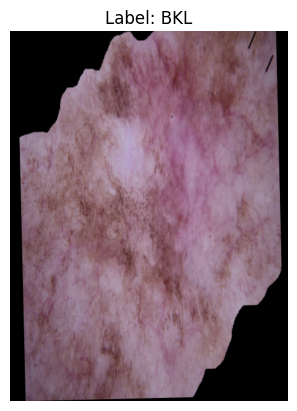

In [29]:
image, label = train_df_dataset[0]  # This returns the masked image and label

# Display the image with its label
show_image_with_label(image, label)

# MODELS

In [31]:
!wandb login 492953ddcda0576b6e6ebf89860aed0ccd177efe

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
run_name = f"resnet, batch=16, lr=0.001, 4000 photos"

In [33]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Skin cancer detection",

    # track hyperparameters and run metadata
    config={
    "epochs" : 50,
    "batch_size" : 16,
    "learning_rate" : 0.001,
    },
    name=run_name
)

wandb: Currently logged in as: kkaterynabilyk (kkaterynabilyk-lviv-polytechnic-national-university). Use `wandb login --relogin` to force relogin


In [34]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [35]:
import wandb

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, config, device):
    best_val_loss = float('inf')  # Для відстеження найкращої моделі

    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = running_loss / len(train_loader)
        f1, recall, precision, accuracy = calculate_metrics(all_labels, all_preds)  # Без include_accuracy
        wandb.log({"epoch": epoch + 1, "loss": avg_loss, "f1_score": f1, "recall": recall, "precision": precision, "accuracy": accuracy})
        print(f'Epoch [{epoch+1}/{config.epochs}], Loss: {avg_loss:.4f}, F1-score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}')
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_preds, val_labels_list = [], []
        
        with torch.no_grad():
            for val_images, batch_labels in val_loader:
                val_images, batch_labels = val_images.to(device), batch_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, batch_labels)
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_preds.extend(val_predicted.cpu().numpy())
                val_labels_list.extend(batch_labels.cpu().numpy())

        avg_val_loss = val_running_loss / len(val_loader)
        val_f1, val_recall, val_precision, val_accuracy = calculate_metrics(val_labels_list, val_preds)  # Без include_accuracy
        wandb.log({"val_loss": avg_val_loss, "val_f1_score": val_f1, "val_recall": val_recall, "val_precision": val_precision, "val_accuracy": val_accuracy})
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation F1-score: {val_f1:.4f}, Validation Recall: {val_recall:.4f}, Validation Precision: {val_precision:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        # Save the best model as a wandb artifact
        if avg_val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
            
            model_save_path = f"best_model_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), model_save_path)
            
            artifact = wandb.Artifact('best_model', type='model')
            artifact.add_file(model_save_path)
            wandb.log_artifact(artifact)

            best_val_loss = avg_val_loss
        
        # Learning Rate Scheduler
        scheduler.step(avg_val_loss)
        
        # Early Stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

# ResNet50

In [37]:
class SkinLesionClassifier_Resnet50(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_Resnet50, self).__init__()
        self.freeze_base = freeze_base
        
        self.base_model = models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
            for param in self.base_model.layer4.parameters():
                param.requires_grad = True
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )
         
    def forward(self, x):
        return self.base_model(x)

In [38]:
# def calculate_metrics(y_true, y_pred):
#     precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
#     recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
#     f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
#     accuracy = accuracy_score(y_true, y_pred)

#     return f1, recall, precision, accuracy

def calculate_metrics(labels, preds):
    f1 = f1_score(labels, preds, average='weighted')  
    recall = recall_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    
    return f1, recall, precision, accuracy

In [41]:
config = wandb.config

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))


In [43]:
model = SkinLesionClassifier_Resnet50(num_classes=7).to(device)

In [44]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
early_stopping = EarlyStopping(patience=5, verbose=True)

In [45]:
train_loader = DataLoader(train_df_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_df_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_df_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

In [46]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, config, device)

Epoch [1/50], Loss: 1.1502, F1-score: 0.4767, Recall: 0.4887, Precision: 0.5438, Accuracy: 0.4887


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.8770, Validation F1-score: 0.5772, Validation Recall: 0.5800, Validation Precision: 0.6455, Validation Accuracy: 0.5800
Validation loss decreased (inf --> 0.8770). Saving model...
Epoch [2/50], Loss: 0.8819, F1-score: 0.5956, Recall: 0.6086, Precision: 0.6186, Accuracy: 0.6086


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.8013, Validation F1-score: 0.6133, Validation Recall: 0.6200, Validation Precision: 0.6706, Validation Accuracy: 0.6200
Validation loss decreased (0.8770 --> 0.8013). Saving model...
Epoch [3/50], Loss: 0.7006, F1-score: 0.6731, Recall: 0.6863, Precision: 0.7084, Accuracy: 0.6863
Validation Loss: 0.7254, Validation F1-score: 0.7345, Validation Recall: 0.7360, Validation Precision: 0.7661, Validation Accuracy: 0.7360
Validation loss decreased (0.8013 --> 0.7254). Saving model...
Epoch [4/50], Loss: 0.6242, F1-score: 0.7227, Recall: 0.7284, Precision: 0.7397, Accuracy: 0.7284
Validation Loss: 0.7352, Validation F1-score: 0.7822, Validation Recall: 0.7880, Validation Precision: 0.7954, Validation Accuracy: 0.7880
EarlyStopping counter: 1 out of 5
Epoch [5/50], Loss: 0.5335, F1-score: 0.7682, Recall: 0.7704, Precision: 0.7805, Accuracy: 0.7704
Validation Loss: 0.6167, Validation F1-score: 0.7346, Validation Recall: 0.7500, Validation Precision: 0.7774, Validation Accurac

## Efficient net b5

In [32]:
class SkinLesionClassifier_EfficientNet(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_EfficientNet, self).__init__()
        
        # Load pre-trained EfficientNet
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freezing base model layers except for the classifier
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False  # Freeze all layers by default
            for param in self.base_model.classifier.parameters():  # Unfreeze the classifier layers
                param.requires_grad = True

        # Getting the number of input features to the classifier
        num_features = self.base_model.classifier[1].in_features  # Number of features for the classifier

        # Replace the classifier with a new one
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 512),  # First fully connected layer
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Output layer for classification
        )
    
    def forward(self, x):
        return self.base_model(x)


In [37]:
model_effnet = SkinLesionClassifier_EfficientNet(num_classes=7).to(device)

In [38]:
early_stopping_2 = EarlyStopping(patience=5, verbose=True)
optimizer_2 = optim.Adam(model_effnet.parameters(), lr=config.learning_rate)
scheduler_2 = ReduceLROnPlateau(optimizer_2, 'min', patience=3, factor=0.1)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [39]:
train_model(model_effnet, train_loader, val_loader, criterion, optimizer_2, scheduler_2, early_stopping_2, config, device)

Epoch [1/50], Loss: 1.1430, F1-score: 0.4728, Recall: 0.4812, Precision: 0.5340, Accuracy: 0.4812
tensor([4, 3, 2, 3, 4, 1, 4, 0, 3, 6, 1, 4, 0, 5, 3, 1], device='cuda:0')
tensor([3, 0, 4, 2, 0, 3, 6, 4, 0, 0, 0, 4, 4, 0, 6, 3], device='cuda:0')
tensor([2, 0, 0, 3, 3, 3, 3, 1, 4, 3, 6, 3, 2, 3, 3, 4], device='cuda:0')
tensor([2, 3, 2, 6, 1, 2, 6, 2, 1, 4, 3, 6, 1, 2, 3, 4], device='cuda:0')
tensor([4, 2, 4, 2, 0, 3, 2, 3, 2, 3, 0, 3, 4, 4, 6, 3], device='cuda:0')
tensor([0, 2, 2, 1, 1, 1, 6, 3, 3, 2, 3, 0, 2, 3, 1, 1], device='cuda:0')
tensor([4, 3, 2, 2, 3, 2, 6, 4, 3, 3, 1, 3, 1, 3, 1, 1], device='cuda:0')
tensor([1, 1, 0, 4, 6, 4, 4, 3, 3, 6, 0, 2, 0, 1, 6, 2], device='cuda:0')
tensor([2, 3, 2, 4, 2, 1, 1, 4, 2, 3, 3, 2, 1, 0, 0, 0], device='cuda:0')
tensor([3, 0, 3, 0, 4, 4, 3, 5, 6, 0, 0, 3, 3, 6, 1, 3], device='cuda:0')
tensor([3, 4, 4, 0, 6, 1, 0, 2, 6, 4, 3, 3, 1, 1, 3, 4], device='cuda:0')
tensor([3, 1, 1, 1, 3, 0, 4, 0, 1, 3, 0, 4, 1, 6, 2, 1], device='cuda:0')
tensor([3, 1, 

In [ ]:
class SkinLesionClassifier_InceptionV3(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_InceptionV3, self).__init__()
        # Використовуємо переднавчену модель InceptionV3
        self.base_model = models.inception_v3(pretrained=True, aux_logits=True)
        
        # Заморожуємо ваги базової моделі (крім останнього блоку)
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
            for param in self.base_model.fc.parameters():
                param.requires_grad = True
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)  # Без Dropout
        )
    
    def forward(self, x):
        outputs = self.base_model(x)
        if isinstance(outputs, tuple):  # Якщо є aux_logits, повертає кортеж
            logits, _ = outputs
        else:  # Якщо немає aux_logits (у валідації), повертає просто logits
            logits = outputs
        return logits

In [ ]:
model_inception = SkinLesionClassifier_InceptionV3(num_classes=7).to(device)

In [ ]:
early_stopping_3 = EarlyStopping(patience=5, verbose=True)
optimizer_3 = optim.Adam(model_inception.parameters(), lr=config.learning_rate)
scheduler_3 = ReduceLROnPlateau(optimizer_3, 'min', patience=3, factor=0.1)

In [ ]:
train_model(model_inception, train_loader, val_loader, criterion, optimizer_3, scheduler_3, early_stopping_3, config, device)

In [ ]:
import torch.nn as nn
import torchvision.models as models

class SkinLesionClassifier_SqueezeNet(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_SqueezeNet, self).__init__()
        self.base_model = models.squeezenet1_1(pretrained=True)
        
        # Замінюємо останній класифікаційний шар перед замороженням
        self.base_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
        
        # Заморожуємо ваги базової моделі (крім нового класифікаційного шару)
        if freeze_base:
            for param in self.base_model.features.parameters():
                param.requires_grad = False
        
        # Новий класифікаційний шар має навчатись
        for param in self.base_model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)


In [ ]:
model_squeeze = SkinLesionClassifier_SqueezeNet(num_classes=7).to(device)

In [ ]:
early_stopping_4 = EarlyStopping(patience=5, verbose=True)
optimizer_4 = optim.Adam(model_squeeze.parameters(), lr=config.learning_rate)
scheduler_4 = ReduceLROnPlateau(optimizer_4, 'min', patience=3, factor=0.1)

In [ ]:
train_model(model_squeeze, train_loader, val_loader, criterion, optimizer_4, scheduler_4, early_stopping_4, config, device)

In [ ]:
torch.save(model_squeeze.state_dict(), "cnn_classifier.pth")
wandb.save("cnn_classifier.pth")

In [ ]:
class SkinLesionClassifier_AlexNet(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_AlexNet, self).__init__()
        self.base_model = models.alexnet(pretrained=True)

        if freeze_base:
            for param in self.base_model.features.parameters():
                param.requires_grad = False  # Заморожуємо CONV шари
            for param in self.base_model.classifier.parameters():
                param.requires_grad = True  # Розморожуємо лише класифікатор

        # Оновлений класифікаційний шар
        self.base_model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [ ]:
model_alexnet = SkinLesionClassifier_AlexNet(num_classes=7).to(device)
early_stopping_5 = EarlyStopping(patience=5, verbose=True)
optimizer_5 = optim.Adam(model_alexnet.parameters(), lr=config.learning_rate)
scheduler_5 = ReduceLROnPlateau(optimizer_5, 'min', patience=3, factor=0.1)

In [ ]:
train_model(model_alexnet, train_loader, val_loader, criterion, optimizer_5, scheduler_5, early_stopping_5, config, device)

In [51]:
class SkinLesionClassifier_VGG(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_VGG, self).__init__()
        self.base_model = models.vgg16(pretrained=True)

        if freeze_base:
            for param in self.base_model.features.parameters():
                param.requires_grad = False

        # Зменшена кількість нейронів і BatchNorm
        self.base_model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [52]:
model_vgg = SkinLesionClassifier_VGG(num_classes=7, freeze_base=True).to(device)

In [53]:
early_stopping_6 = EarlyStopping(patience=5, verbose=True)
optimizer_6 = optim.Adam(model_vgg.parameters(), lr=config.learning_rate)
scheduler_6 = ReduceLROnPlateau(optimizer_6, 'min', patience=3, factor=0.1)

In [ ]:
train_model(model_vgg, train_loader, val_loader, criterion, optimizer_6, scheduler_6, early_stopping_6, config, device)

Epoch [1/50], Loss: 1.6907, F1-score: 0.2135, Recall: 0.2401, Precision: 0.2653, Accuracy: 0.2401
Validation Loss: 1.3053, Validation F1-score: 0.2646, Validation Recall: 0.3440, Validation Precision: 0.4041, Validation Accuracy: 0.3440
Validation loss decreased (inf --> 1.3053). Saving model...


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 1.2573, F1-score: 0.3555, Recall: 0.4060, Precision: 0.4091, Accuracy: 0.4060


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.0356, Validation F1-score: 0.4611, Validation Recall: 0.5240, Validation Precision: 0.5192, Validation Accuracy: 0.5240
Validation loss decreased (1.3053 --> 1.0356). Saving model...


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Loss: 0.9873, F1-score: 0.4702, Recall: 0.5188, Precision: 0.5053, Accuracy: 0.5188


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.9710, Validation F1-score: 0.5133, Validation Recall: 0.5600, Validation Precision: 0.5507, Validation Accuracy: 0.5600
Validation loss decreased (1.0356 --> 0.9710). Saving model...


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/50], Loss: 0.7768, F1-score: 0.5848, Recall: 0.6198, Precision: 0.5973, Accuracy: 0.6198


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.9870, Validation F1-score: 0.5812, Validation Recall: 0.6040, Validation Precision: 0.5745, Validation Accuracy: 0.6040
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/50], Loss: 0.6796, F1-score: 0.6384, Recall: 0.6638, Precision: 0.6514, Accuracy: 0.6638
Validation Loss: 1.0723, Validation F1-score: 0.6276, Validation Recall: 0.6520, Validation Precision: 0.6326, Validation Accuracy: 0.6520
EarlyStopping counter: 2 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/50], Loss: 0.5671, F1-score: 0.7183, Recall: 0.7371, Precision: 0.7359, Accuracy: 0.7371
Validation Loss: 0.7630, Validation F1-score: 0.6891, Validation Recall: 0.7020, Validation Precision: 0.7132, Validation Accuracy: 0.7020
Validation loss decreased (0.9710 --> 0.7630). Saving model...
Epoch [7/50], Loss: 0.4393, F1-score: 0.7657, Recall: 0.7779, Precision: 0.7674, Accuracy: 0.7779
Validation Loss: 0.7510, Validation F1-score: 0.7195, Validation Recall: 0.7340, Validation Precision: 0.7485, Validation Accuracy: 0.7340
Validation loss decreased (0.7630 --> 0.7510). Saving model...
Epoch [8/50], Loss: 0.3888, F1-score: 0.7979, Recall: 0.8052, Precision: 0.8016, Accuracy: 0.8052
Validation Loss: 0.7791, Validation F1-score: 0.7594, Validation Recall: 0.7640, Validation Precision: 0.7723, Validation Accuracy: 0.7640
EarlyStopping counter: 1 out of 5
Epoch [9/50], Loss: 0.3548, F1-score: 0.8305, Recall: 0.8367, Precision: 0.8313, Accuracy: 0.8367
Validation Loss: 0.7296, Valida